# Male or Female - Let the Model Decide

In this notebook we want to simulate a case where the machine learning algorithm should decide wether an observation is male or female, based on the two uncorrelated features height and hair length. However, we assume that these two features are not time invariant. Hence, our static model (once trained and never changed) will get worse over time. Furthermore, note that we can have several different types of changes which can be categorized with regards to time and impact.

1. Slowly or sudden changes (slowly changing trend vs a new law, or new sensor calibration)
2. Impact of the effect: real covariate shift ($f(x)$ changes), prior probs change ($f(y)$) or concept shift $f(y|x):= f(y;x)$

Definitions (maybe not complete and not very precise):

- $f(x)$ is a probability density function
- $P(X=x) $ is the probability of X being x
- $P(X<x_0) = \int_{-\infty}^{x_0} f(x) dx = F(x_0)  $ (for continous pdfs)
- $P(X=x_0)$ is the probability of $X$ being $x_0$
- $P(X=x|Y=y)$ likelihood of event x given that y happened
- $P(Y=y|X=x)$ (posterior probability) likelihood of event y given that x happened. (This is actually what we try to model.)
- $P(Y=y)$ (prior probability) of Y being y without having observed more data, e.g. X
- $m(\vec{x} = (x_{hair}, x_{height})) = \hat{Y}$ Model returning either a concrete class or probabilities for the different classes
- $\hat{Y} = (P(y_1),...,P(y_N))^T$ or $\hat{Y} = (y_1=1,...,y_N=0)^T$ for N classes
- Bayes (for Probs): $P(Y=y|X=x) = \frac{P(X=x|Y=y)P(Y=y)}{P(X=x)}$
- Bayes (for pdfs): $f_Y(y|X=x) = \frac{f_X(x|Y=y)f_Y(y)}{f_X(x)}$
- $X$ is a random variable which can be one dimensional or k-dimensional

- $P(X=\vec{x})$
- $\bf{x}$
- A, B, C

#### load modules

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

# adjust styles
plt.style.use(['seaborn-paper'])

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [74]:
# set random seed
np.random.seed(42)

### Generate Data

We generate data by using two multivariate gaussian distributions for male and female. Since the features are uncorrelated we can write the density 
as a normal product of two gaussians.

$$f_X(X=(x_1, x_2)| Y=f) = \mathcal{N}(x_1 \vert \mu_1^f = 160 cm, \sigma=10cm) \times \mathcal{N}(x_2 \vert \mu_2^f = 20 cm, \sigma=10cm)$$
$$f_X(X=(x_1, x_2)| Y=m) = \mathcal{N}(x_1 \vert \mu_1^m = 180 cm, \sigma=15cm) \times \mathcal{N}(x_2 \vert \mu_2^m = 5 cm, \sigma=2cm)$$

For both classes (f,m) we generate 6000 observations. Hence, we get:

$$P(Y=f) = P(Y=m) = 0.5$$ as a prior.

Finally, the data gets trimmed (and hence is not a real gaussian, since hair length cannot be negative, etc.)

In [75]:
def gauss(x,y,mu_x, mu_y, s_x, s_y):
    return norm.pdf(x, loc=mu_x, scale=s_x) * norm.pdf(y, loc=mu_y, scale=s_y)

In [76]:
x = np.linspace(0,50,100)
y = np.linspace(120,220,100)
X,Y = np.meshgrid(x, y) # grid of point

In [77]:
Z = gauss(X,Y,20,160, 10,10)
Z

array([[7.22562324e-08, 7.98343055e-08, 8.79824415e-08, ...,
        7.98965330e-09, 6.89266881e-09, 5.93115274e-09],
       [1.07679311e-07, 1.18972478e-07, 1.31115177e-07, ...,
        1.19065212e-08, 1.02717483e-08, 8.83885610e-09],
       [1.58839350e-07, 1.75498068e-07, 1.93409943e-07, ...,
        1.75634861e-08, 1.51520083e-08, 1.30383278e-08],
       ...,
       [1.08015430e-11, 1.19343848e-11, 1.31524450e-11, ...,
        1.19436872e-12, 1.03038113e-12, 8.86644643e-13],
       [5.98306483e-12, 6.61055537e-12, 7.28524909e-12, ...,
        6.61570803e-13, 5.70736710e-13, 4.91119868e-13],
       [3.28042787e-12, 3.62447186e-12, 3.99439667e-12, ...,
        3.62729699e-13, 3.12926680e-13, 2.69273918e-13]])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


<a list of 0 text.Text objects>

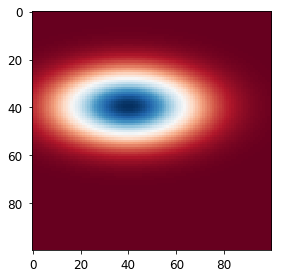

In [78]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,np.arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

In [79]:
# height gaussians
height_f = np.random.normal(loc=160, scale=10, size=6000)
height_m = np.random.normal(loc=180, scale=15, size=6000)

In [80]:
# hair gaussians
hair_f = np.random.normal(loc=20, scale=10, size=6000)
hair_m = np.random.normal(loc=5, scale=2, size=6000)

In [81]:
# combine dfs
df_m = pd.DataFrame({'hair': hair_m, 'height': height_m, 'sex': np.repeat(1, 6000)})
df_f = pd.DataFrame({'hair': hair_f, 'height': height_f, 'sex': np.repeat(0, 6000)})
df = pd.concat([df_m, df_f], axis=0, ignore_index=True)

In [82]:
# modify dfs
df['hair'] = np.where(df['hair'] < 0, 0 , df['hair'])
df['height'] = np.where(df['height'] < 120, 120, df['height'] )
df['height'] = np.where(df['height'] > 220, 220, df['height'] )

In [83]:
df.describe()

,hair,height,sex
count,12000.000000,12000.000000,12000.000000
mean,12.671706,169.909700,0.500000
std,10.454977,16.174742,0.500021
min,0.000000,121.163996,0.000000
25%,4.677372,158.176041,0.000000
50%,7.567095,167.795818,0.500000
75%,20.318668,180.490088,1.000000
max,64.790843,220.000000,1.000000


In [84]:
df.groupby('sex').describe()

hair                                                             \
      count       mean       std  min        25%        50%        75%   
sex                                                                      
0    6000.0  20.352876  9.833779  0.0  13.418900  20.319497  27.066147   
1    6000.0   4.990536  1.976783  0.0   3.604894   4.982797   6.349340   

                height                                                 \
           max   count        mean        std         min         25%   
sex                                                                     
0    64.790843  6000.0  159.968787   9.984125  127.587327  153.364687   
1    12.884662  6000.0  179.850613  15.030933  121.163996  169.783494   

                                         
            50%         75%         max  
sex                                      
0    160.019535  166.568560  199.262377  
1    179.719048  190.043868  220.000000

# Split data in train, val and test using stratified sampling for y

In [85]:
X, y = df.drop(['sex'], axis=1), df['sex']

In [86]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, stratify=y,  test_size=0.4)

In [87]:
X_test, X_val, y_test, y_val = train_test_split(X_test_temp, y_test_temp, stratify=y_test_temp,  test_size=0.5)

In [88]:
y_val.describe()

count    2400.000000
mean        0.500000
std         0.500104
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: sex, dtype: float64

## Build a model

Here, we build a simple logistic regression model ($m(X=(x_1, x_2))$. The decision boundary will be a simple line on the two dimensional feature space.

In [89]:
# init model
clf = LogisticRegression(solver='lbfgs')

In [90]:
# train model
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [91]:
# get hard and soft predictions
y_pred = clf.predict(X_val)
y_pred_proba = clf.predict_proba(X_val)[:,0]

### Decision Boundary
Trained on df_train and tested on x_val (points are X_val)

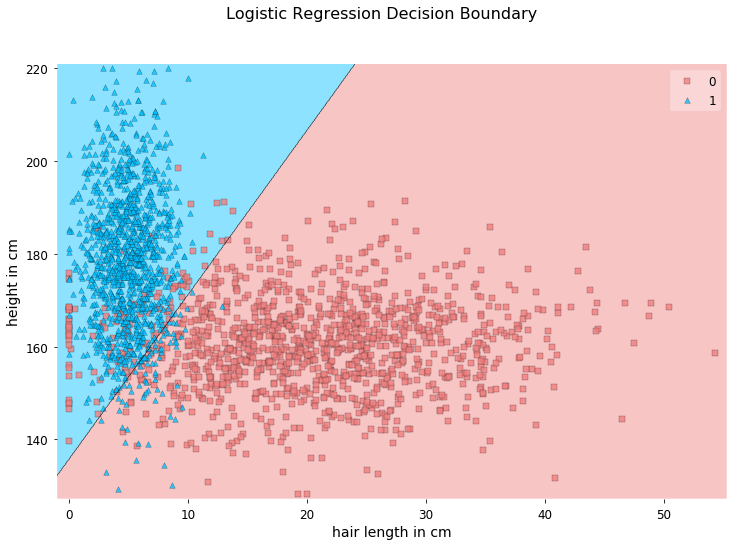

In [92]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=X_val.values, y=y_val.values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True )
fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
fig.savefig('Decision_Boundary.pdf', bbox_inches='tight')

In [93]:
# metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1200
           1       0.91      0.94      0.92      1200

   micro avg       0.92      0.92      0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



In [95]:
clf.score(X_val, y_val)

0.9195833333333333

### Distributions of the test data (which we can monitor)

The distributions we can observe/monitor are:
1. $f_X(\vec{x}=(x_1, x_2)) \sim \exp(-x_1)^2 \exp(-x_2)^2$
2. $f_{\hat{Y}} $ distribution of a probability (not just a probability distribution)

Furthermore, we could also monitor:  
3. $f_X(X \vert \hat{Y} = m,f)$ # dont kow if this is useful

We can observe temporal changes in different ways:

1. Comparing two rolling windows:
 - Disadvantage: Slowly changing dists not really observable
 - Advantage: hm, no idea?
2. Against a static reference:
 - Advantage: Slowly changing dist observable
 - Advantage: Since you usually know the labels from the static reference, you can estimate the impact of the change


In [69]:
df_test = X_test.copy()
df_test['sex'] = y_test

### 1. $f_X(x_1,x_2)$

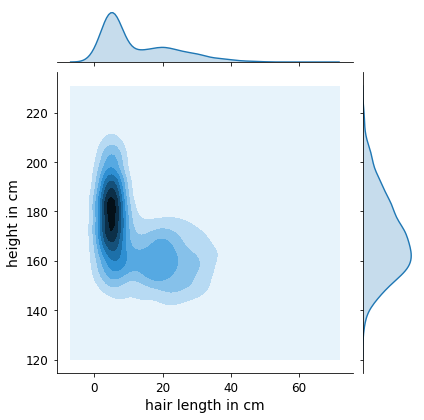

In [70]:
# p(x)
g = sns.jointplot(data=df_test, x='hair', y='height', kind='kde')
g.set_axis_labels('hair length in cm', 'height in cm')
g.savefig('joint_px.pdf', bbox_inches='tight')

### 2. $f_Y(y \vert X)$

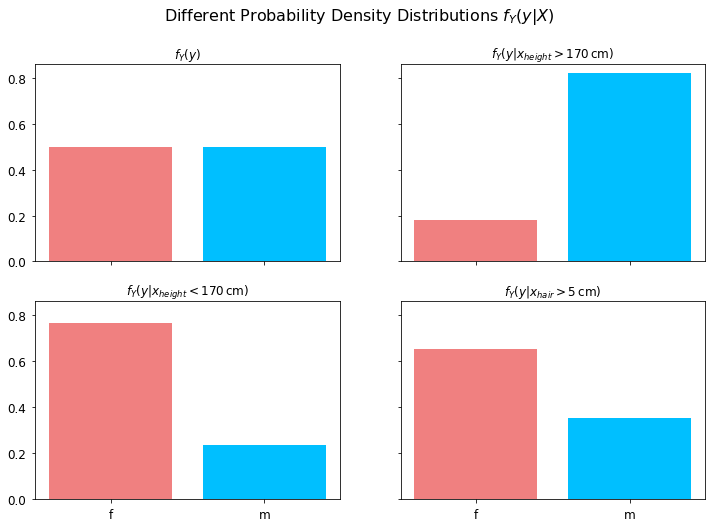

In [71]:
# p(y)

counts_full = df_test['sex'].value_counts(normalize=True)
counts_cond1 = df_test[df_test['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test[df_test['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test[df_test['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle(r'Different Probability Density Distributions $f_Y(y|X )$')
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r'$f_Y(y)$')
ax[0,1].set_title(r'$f_Y(y\vert x_{height} > 170 \, \mathrm{cm})$')
ax[1,0].set_title(r'$f_Y(y\vert x_{height} < 170\, \mathrm{cm})$')
ax[1,1].set_title(r'$f_Y(y\vert x_{hair} > 5\, \mathrm{cm})$')

fig.savefig('cond_py.pdf', bbox_inches='tight')

As expected:
- upper right show the balanced data set

#### 3a). $f_X(x_1,x_2\vert Y)$    not observable

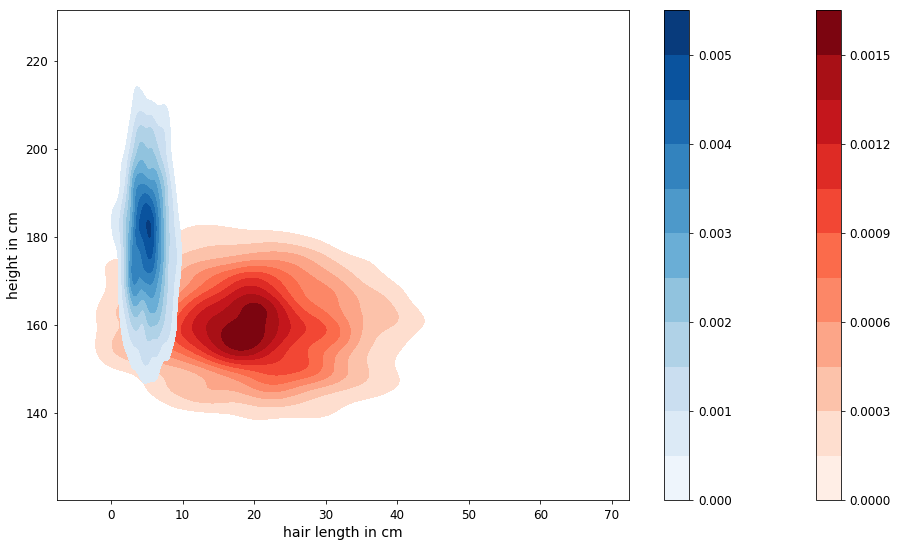

In [72]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test[df_test['sex'] == 1]
df_f = df_test[df_test['sex'] == 0]
sns.kdeplot(df_f['hair'], df_f['height'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['hair'], df_m['height'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )
#fig.suptitle(r"Probability Density Distributions $f_X(X=(x_1, x_2)\vert y=f,m)$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_px.pdf', bbox_inches='tight')
#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

In [57]:
df_test['y_hat'] = clf.predict_proba(X_test)[:,0]

In [61]:
df_test.head()

,hair,height,sex,y_hat
5082,5.440490,188.099264,1,0.020533
10016,5.613630,155.191662,0,0.488601
11726,20.258818,137.917192,0,0.999722
5101,3.202501,165.129984,1,0.099002
373,3.448191,199.116426,1,0.002544


#### 3b). $f_X(x_1,x_2\vert \hat{Y})$  observable

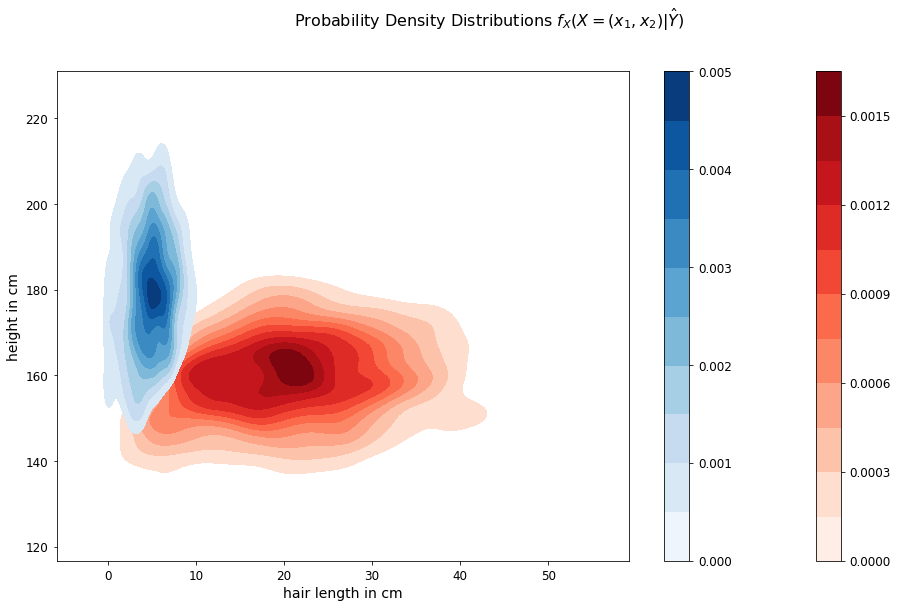

In [69]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test[df_test['y_hat'] <= 0.5]
df_f = df_test[df_test['y_hat'] > 0.5]
sns.kdeplot(df_f['hair'], df_f['height'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['hair'], df_m['height'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )
fig.suptitle(r"Probability Density Distributions $f_X(X=(x_1, x_2)\vert \hat{Y})$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_px_yhat.pdf', bbox_inches='tight')
#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

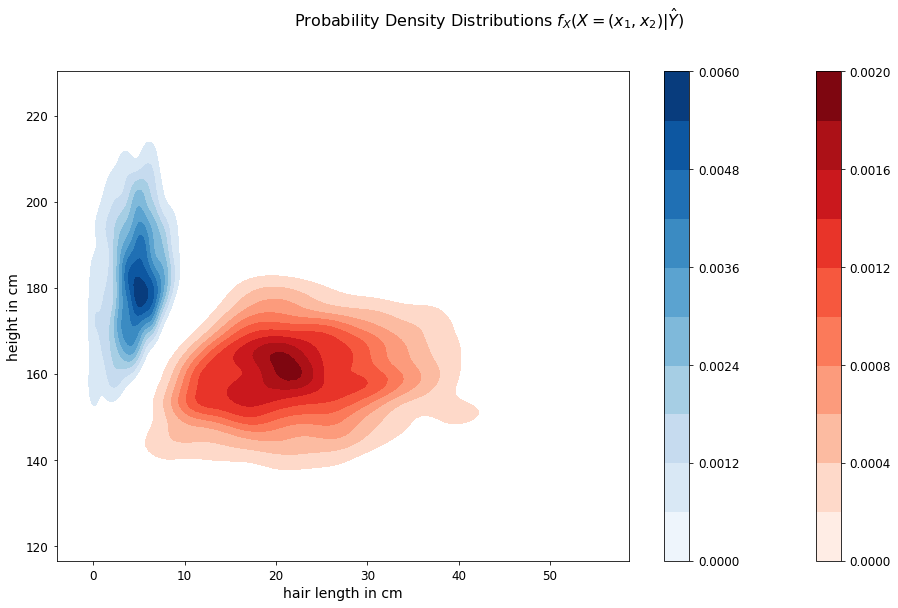

In [68]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test[df_test['y_hat'] <= 0.2]
df_f = df_test[df_test['y_hat'] > 0.8]
sns.kdeplot(df_f['hair'], df_f['height'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['hair'], df_m['height'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )
fig.suptitle(r"Probability Density Distributions $f_X(X=(x_1, x_2)\vert \hat{Y})$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_px_yhat.pdf', bbox_inches='tight')
#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

## Szenario 1: All Females grow more than 15% due to some weird pill. Simultaneously they loose some hair (-10%)
What do we expect:
- $f_X(x)$ and $f_X(x\vert y=f)$ will change
- $f_Y(y), f_X(X \vert y=m)$ will stay the same

Hence (really hence?),
$f(Y\vert X)$ will change, i.e. the actual decision boundary should change and our model $m(X)$ or $f_\hat{Y}(\hat{y}\vert X)$ is not valid anymore.

###  mod data

In [75]:
df_test_1 = df_test.copy()

female_cond = df_test_1['sex'] == 0
df_test_1.loc[female_cond, 'height'] =  df_test_1.loc[female_cond, 'height'] * 1.15
df_test_1.loc[female_cond, 'hair'] =  df_test_1.loc[female_cond, 'hair'] * 0.90

### 1. $f_X(x_1,x_2)$

- has changed

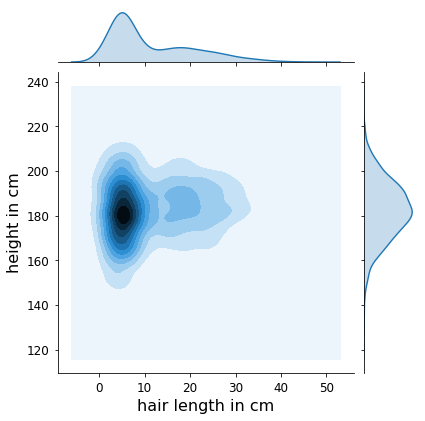

In [76]:
g = sns.jointplot(data=df_test_1, x='hair', y='height', kind='kde')
g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
#g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
g.savefig('joint_pprimex.pdf', bbox_inches='tight')

### 2. not observable 

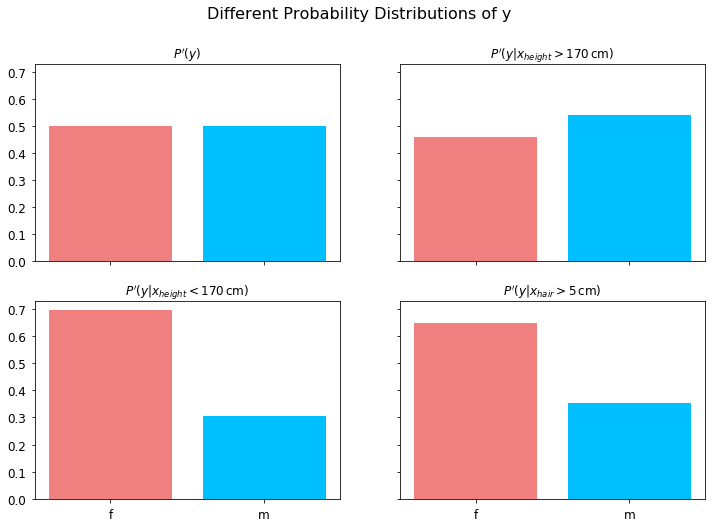

In [77]:
# p(y)

counts_full = df_test_1['sex'].value_counts(normalize=True)
counts_cond1 = df_test_1[df_test_1['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test_1[df_test_1['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test_1[df_test_1['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle("Different Probability Distributions of y")
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r"$P'(y)$")
ax[0,1].set_title(r"$P'(y\vert x_{height} > 170 \, \mathrm{cm})$")
ax[1,0].set_title(r"$P'(y\vert x_{height} < 170\, \mathrm{cm})$")
ax[1,1].set_title(r"$P'(y\vert x_{hair} > 5\, \mathrm{cm})$")

fig.savefig('cond_pprimey.pdf', bbox_inches='tight')

### 3. not observable

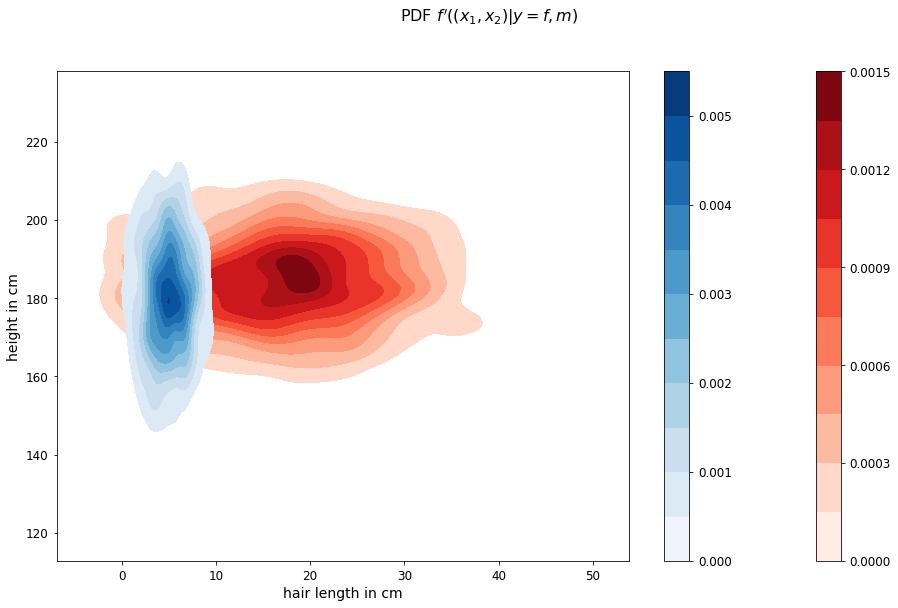

In [78]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test_1[df_test['sex'] == 1]
df_f = df_test_1[df_test['sex'] == 0]
sns.kdeplot(df_f['hair'], df_f['height'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['hair'], df_m['height'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )

fig.suptitle(r"PDF $f'((x_1, x_2)\vert y=f,m)$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_pprimex.pdf', bbox_inches='tight')


#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

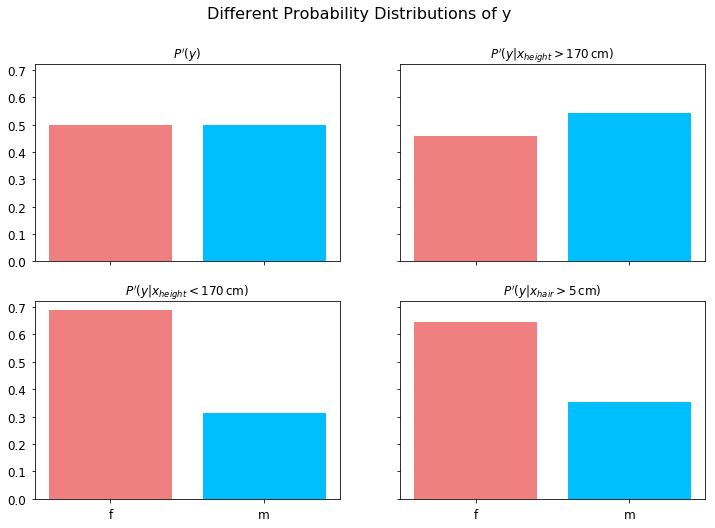

In [27]:
# p(y)

counts_full = df_test_1['sex'].value_counts(normalize=True)
counts_cond1 = df_test_1[df_test_1['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test_1[df_test_1['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test_1[df_test_1['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle("Different Probability Distributions of y")
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r"$P'(y)$")
ax[0,1].set_title(r"$P'(y\vert x_{height} > 170 \, \mathrm{cm})$")
ax[1,0].set_title(r"$P'(y\vert x_{height} < 170\, \mathrm{cm})$")
ax[1,1].set_title(r"$P'(y\vert x_{hair} > 5\, \mathrm{cm})$")

fig.savefig('cond_pprimey.pdf', bbox_inches='tight')

#### Decision boundary should have changed

Text(0, 0.5, 'height in cm')

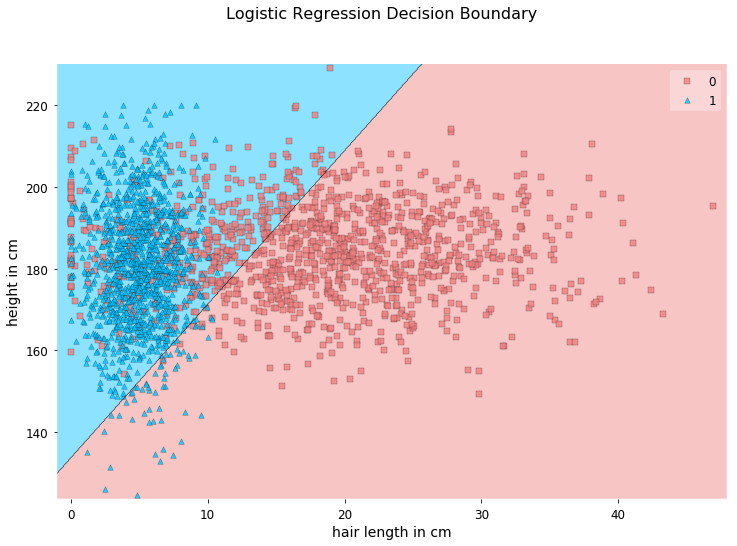

In [79]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True )
fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
#fig.savefig('Decision_Boundary.pdf', bbox_inches='tight')

In [80]:
clf_new_1 = LogisticRegression()

In [81]:
clf_new_1.fit(df_test_1[['hair', 'height']].values, df_test_1['sex'].values)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

[]

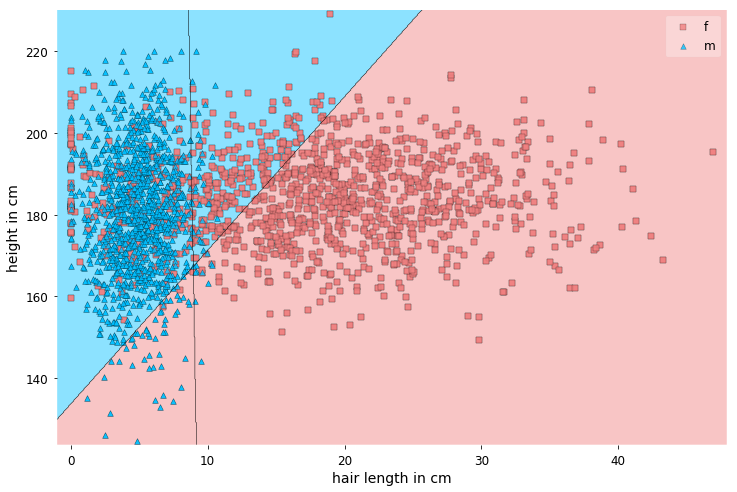

In [82]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True, contourf_kwargs={'linestyles':['dotted', 'dotted']} )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['f', 'm'], 
           framealpha=0.3, scatterpoints=1)
#norml = colors.BoundaryNorm(lev, 256)
plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf_new_1, ax=ax, colors='lightcoral,deepskyblue', legend=False, contourf_kwargs={'alpha':0.0, 'norm':'default'})
#fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
fig.savefig('Decision_Boundary_prime.pdf', bbox_inches='tight')
ax.lines

### bayes

$$P'(Y\vert X) = \frac{P'(X\vert Y) P'(Y)}{P'(X)} = \frac{P'(X\vert Y) P(Y)}{P'(X)}$$

The only terms where we can observe the changes are: $P'(X)$ and the output distribution of our model $F(\hat{y}=f(x))$.

In [84]:
# how early can we detect the change?

In [85]:
proba_hist = clf.predict_proba(X_val)[:,0]
proba_new = clf.predict_proba(df_test_1[['hair', 'height']])[:,0]

In [86]:
proba_new.max()

0.999999504762861

In [87]:
proba_comb = np.concatenate([proba_hist,proba_new])

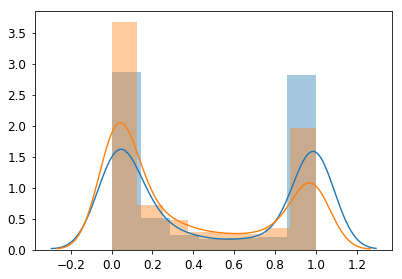

In [88]:
sns.distplot(proba_hist)
sns.distplot(proba_new)

In [89]:
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in proba_new:
    samples.append(element)
    k, p = ks_2samp(proba_hist, samples)
    ks_stats.append(p)

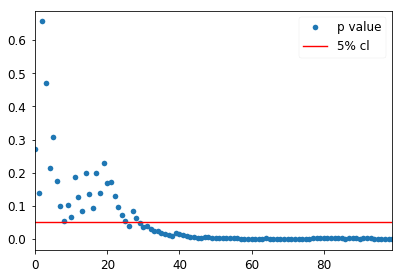

In [90]:
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- we can detect the concept drift since we predict more men than women now
- this does not mean that there is actually a concept drift, as we will see in the next example
- a sample size of 40 is sufficient to reject the null hypothesis: *the two samples originate from the same distribution*

In [91]:
# p(hair)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_1['hair']:
    samples.append(element)
    k, p = ks_2samp(X_val['hair'], samples)
    ks_stats.append(p)

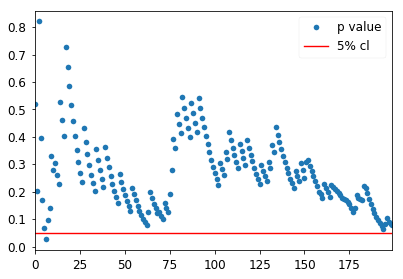

In [92]:
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(200).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- we can detect the concept drift since we predict more men than women now
- this does not mean that there is actually a concept drift, as we will see in the next example
- for p(hair) we need a larger sample size to detect some changes: whatever this change was

In [93]:
# p(height)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_1['height']:
    samples.append(element)
    k, p = ks_2samp(X_val['height'], samples)
    ks_stats.append(p)

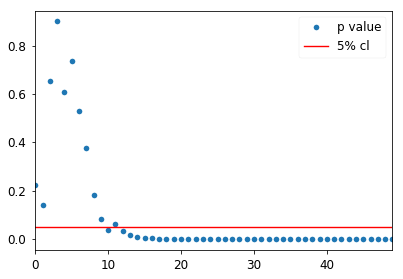

In [94]:
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(50).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- p value drops fast (height has changed the most)

### Szenario 2: Due to the pills 70 % of the women died. Those who survived did not take the pill anymore and have the ordinary height and hair length.

In [95]:
df_test_2 = df_test.copy()

In [96]:
df_f = df_test_2[df_test_2.sex == 0]
df_m = df_test_2[df_test_2.sex == 1]

In [97]:
#df_m

In [98]:
df_f_new = df_f.head(360)

In [99]:
df_test_2 = pd.concat([df_f_new, df_m], axis=0)

In [100]:
df_test_2.head()

,hair,height,sex,y_hat
10016,5.613630,155.191662,0,0.488601
11726,20.258818,137.917192,0,0.999722
10441,8.637298,162.231531,0,0.609908
6678,17.980864,169.356784,0,0.974266
8902,10.701523,154.301671,0,0.903144


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


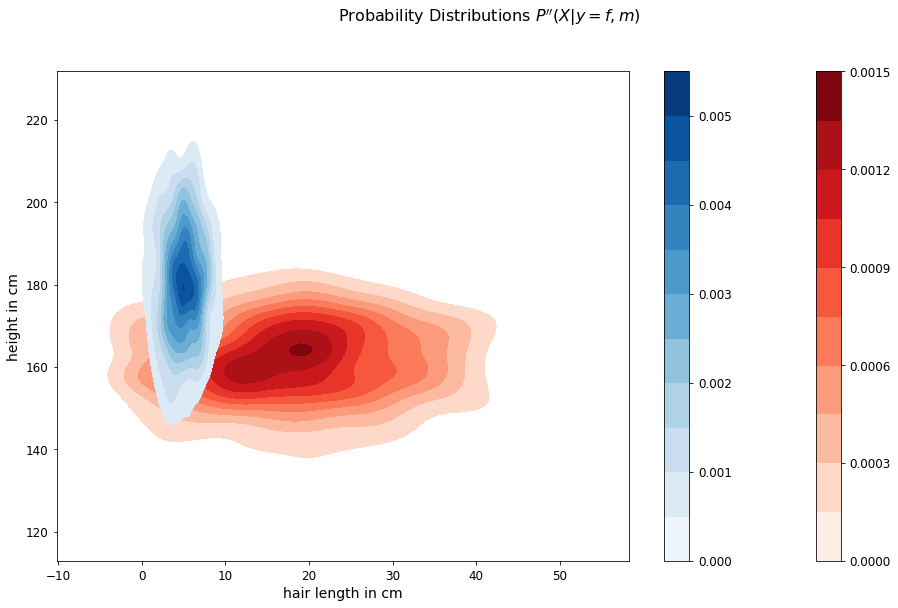

In [104]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test_2[df_test['sex'] == 1]
df_f = df_test_2[df_test['sex'] == 0]
sns.kdeplot(df_f['hair'], df_f['height'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['hair'], df_m['height'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )

fig.suptitle(r"Probability Distributions $P''(X\vert y=f,m)$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_ppprimex.pdf', bbox_inches='tight')


#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

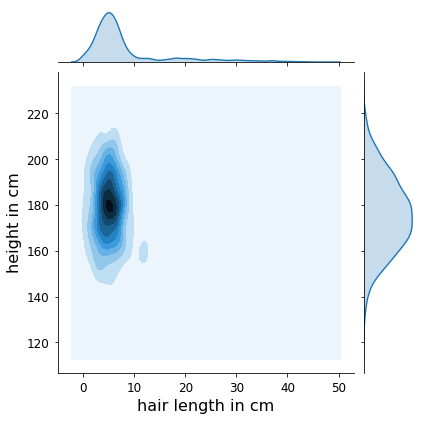

In [105]:
# p(x)
g = sns.jointplot(data=df_test_2, x='hair', y='height', kind='kde')
g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
#g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
g.savefig('joint_ppprimex.pdf', bbox_inches='tight')

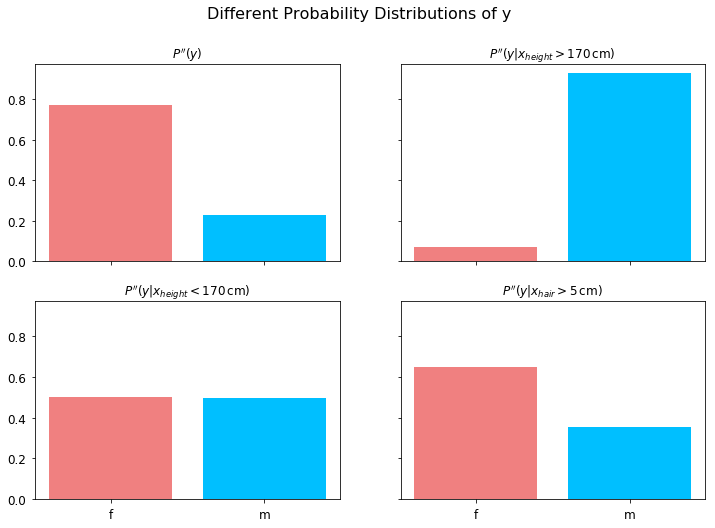

In [106]:
# p(y)

counts_full = df_test_2['sex'].value_counts(normalize=True)
counts_cond1 = df_test_2[df_test_2['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test_2[df_test_2['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test_2[df_test_2['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle("Different Probability Distributions of y")
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r"$P''(y)$")
ax[0,1].set_title(r"$P''(y\vert x_{height} > 170 \, \mathrm{cm})$")
ax[1,0].set_title(r"$P''(y\vert x_{height} < 170\, \mathrm{cm})$")
ax[1,1].set_title(r"$P''(y\vert x_{hair} > 5\, \mathrm{cm})$")

fig.savefig('cond_ppprimey.pdf', bbox_inches='tight')

[]

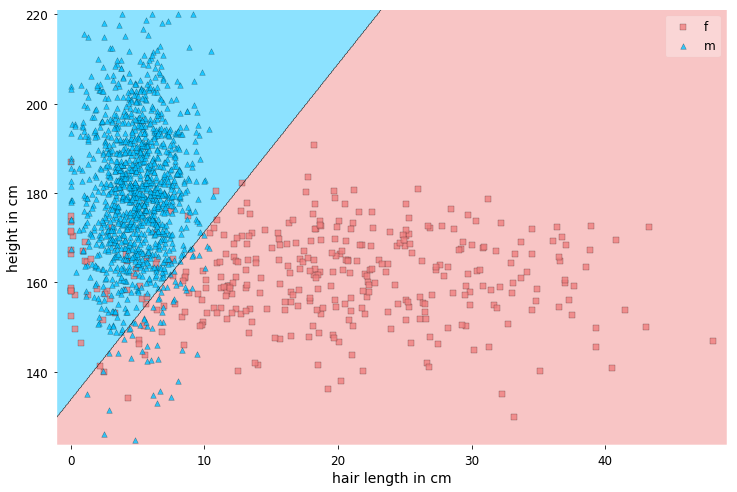

In [107]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=df_test_2[['hair', 'height']].values, y=df_test_2['sex'].values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True, contourf_kwargs={'linestyles':['dotted', 'dotted']} )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['f', 'm'], 
           framealpha=0.3, scatterpoints=1)
#norml = colors.BoundaryNorm(lev, 256)
#plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf_new_1, ax=ax, colors='lightcoral,deepskyblue', legend=False, contourf_kwargs={'alpha':0.0, 'norm':'default'})
#fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
fig.savefig('Decision_Boundary_ppprime.pdf', bbox_inches='tight')
ax.lines

- real decision boundary has actually not changed
- dataset is a bit more imbalanced now

### bayes
$$P'(Y\vert X) = \frac{P'(X\vert Y) P'(Y)}{P'(X)} = \frac{P'(X\vert Y) P'(Y)}{P'(X)}$$

- P'(X\vert Y) changed only slightly (depends on the women who died, actually it is possible that it has not changed)
- P'(Y) changed
- P'(X) changed

let's have a look at our observables


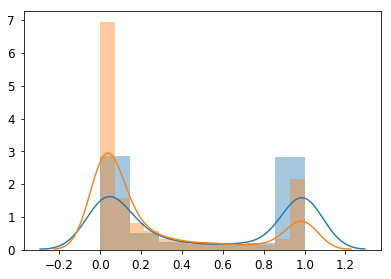

In [108]:
proba_hist = clf.predict_proba(X_val)[:,0]
proba_new = clf.predict_proba(df_test_2[['hair', 'height']])[:,0]
proba_comb = np.concatenate([proba_hist,proba_new])

sns.distplot(proba_hist)
sns.distplot(proba_new)

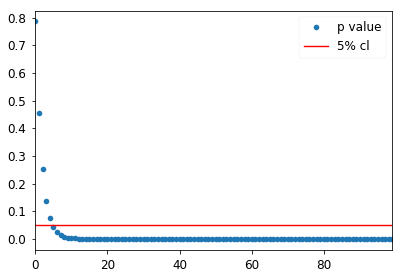

In [109]:
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in proba_new:
    samples.append(element)
    k, p = ks_2samp(proba_hist, samples)
    ks_stats.append(p)
    
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

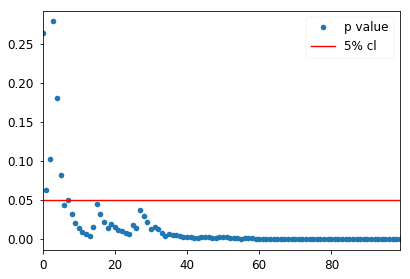

In [110]:
# p(height)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_2['height']:
    samples.append(element)
    k, p = ks_2samp(X_val['height'], samples)
    ks_stats.append(p)
    
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

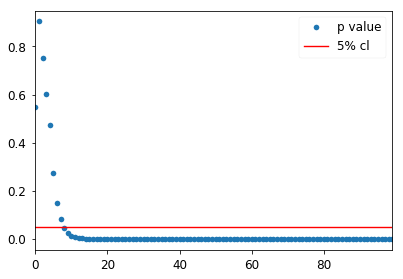

In [111]:
# p(height)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_2['hair']:
    samples.append(element)
    k, p = ks_2samp(X_val['hair'], samples)
    ks_stats.append(p)
    
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- we see similar effects as in the previous example
- however, the decision boundary has not really changed (i.e. it is still the optimal one)
- P(Y\vert X) has changed

### Szenario 3: Some men decided to become man? Makes problem very difficult (label swap)

Since so many women died, some men need to become women in order to ...

In [112]:
proba_hist = clf.predict_proba(X_val)[:,0]
proba_new = clf.predict_proba(df_test_2[['hair', 'height']])[:,0]
proba_comb = np.concatenate([proba_hist,proba_new])

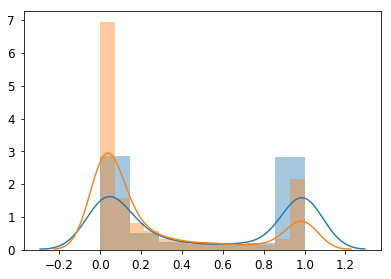

In [113]:
sns.distplot(proba_hist)
sns.distplot(proba_new)